In [38]:
import pandas as pd

ds_names = [1,2,5,6,14,104]

data_samples = {}

for ds_name in ds_names:
    for i in range(1, 3):
        try:
            data_samples[f'{ds_name}_{i}'] = pd.read_csv(f'../data/winter_samples/dataset_{ds_name}_season_{i}.csv')
        except Exception as e:
            continue

## NeuralForecast

In [39]:
import pandas as pd

records = []

for uid, df_series in data_samples.items():
    df_series = df_series.rename(columns={df_series.columns[1]: 'y'})
    df_series = df_series[['full_date', 'y']].copy()
    df_series['unique_id'] = uid
    df_series = df_series.rename(columns={'full_date': 'ds'})
    records.append(df_series)

df_all = pd.concat(records, ignore_index=True)

In [40]:
test_df = df_all[df_all['unique_id'].isin(['1_2', '14_1'])]
train_df = df_all[~df_all['unique_id'].isin(['1_2', '14_1'])]

<Axes: >

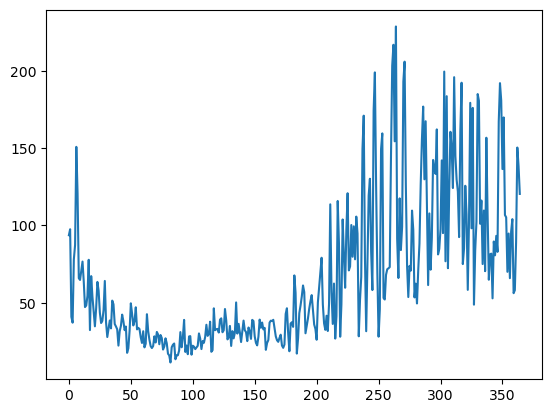

In [71]:
train_df[train_df['unique_id']=='1_1']['y'].plot()

In [41]:
horizon = 125
train_df = train_df.sort_values(['unique_id', 'ds'])

In [42]:
from neuralforecast.auto import AutoLSTM
from neuralforecast.tsdataset import TimeSeriesDataset

train_df['ds'] = pd.to_datetime(train_df['ds']) 
test_df['ds'] = pd.to_datetime(test_df['ds']) 
train_dataset, indices, dates, ds_arr = TimeSeriesDataset.from_df(
    df=train_df,
    id_col="unique_id",
    time_col="ds",
    target_col="y"
)
test_dataset, indices, dates, ds_arr = TimeSeriesDataset.from_df(
    df=test_df,
    id_col="unique_id",
    time_col="ds",
    target_col="y"
)

C:\Users\PC314\AppData\Local\Temp\ipykernel_3868\300558927.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['ds'] = pd.to_datetime(test_df['ds'])


In [43]:
from ray import tune

def optuna_config(trial):
    return {
        # "input_size_multiplier": trial.suggest_categorical("input_size_multiplier", [-1, 4, 16, 64]),
        # "inference_input_size_multiplier": -1,  # single value, no need to tune
        "h": None,  # set externally
        "encoder_hidden_size": trial.suggest_categorical("encoder_hidden_size", [16, 32, 64, 128]),
        "encoder_n_layers": trial.suggest_int("encoder_n_layers", 1, 3),  # randint(1, 4) → [1, 2, 3]
        "context_size": trial.suggest_categorical("context_size", [5, 10, 50]),
        "decoder_hidden_size": trial.suggest_categorical("decoder_hidden_size", [16, 32, 64, 128]),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        "max_steps": trial.suggest_categorical("max_steps", [500, 1000]),
        "batch_size": trial.suggest_categorical("batch_size", [16, 32]),
        "loss": None,  # set externally
        "random_seed": trial.suggest_int("random_seed", 1, 19),  # randint(1, 20) → [1, 2, ..., 19]
        'start_padding_enabled': True,
        'input_size': 240
    }

model_lstm = AutoLSTM(h=horizon, num_samples=20, backend='optuna', config=optuna_config)

model_lstm.fit(dataset=train_dataset, distributed_config=None)
y_hat = model_lstm.predict(dataset=train_dataset)

[I 2025-03-31 18:27:01,133] A new study created in memory with name: no-name-d3231bc2-cded-44cd-b55d-6e30fa787075
Seed set to 11
c:\Users\PC314\anaconda3\Lib\site-packages\neuralforecast\models\lstm.py:161: UserWarning: context_size is deprecated and will be removed in future versions.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 1.2 K  | train
4 | mlp_decoder  | MLP           | 289    | train
-------------------------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)
10        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-03-31 18:27:25,566] Trial 0 finished with value: 56.487945556640625 and parameters: {'encoder_hidden_size': 16, 'encoder_n_layers': 1, 'context_size': 50, 'decoder_hidden_size': 16, 'learning_rate': 0.00020472156554059384, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 11}. Best is trial 0 with value: 56.487945556640625.
Seed set to 3
c:\Users\PC314\anaconda3\Lib\site-packages\neuralforecast\models\lstm.py:161: UserWarning: context_size is deprecated and will be removed in future versions.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 83.7 K | train
4 | mlp_

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-03-31 18:29:14,522] Trial 1 finished with value: 63.2263298034668 and parameters: {'encoder_hidden_size': 64, 'encoder_n_layers': 3, 'context_size': 50, 'decoder_hidden_size': 16, 'learning_rate': 0.06432693881434338, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 3}. Best is trial 0 with value: 56.487945556640625.
Seed set to 13
c:\Users\PC314\anaconda3\Lib\site-packages\neuralforecast\models\lstm.py:161: UserWarning: context_size is deprecated and will be removed in future versions.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 67.1 K | train
4 | mlp_decod

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-03-31 18:29:56,769] Trial 2 finished with value: 37.851173400878906 and parameters: {'encoder_hidden_size': 128, 'encoder_n_layers': 1, 'context_size': 50, 'decoder_hidden_size': 32, 'learning_rate': 0.002020575462641115, 'max_steps': 500, 'batch_size': 32, 'random_seed': 13}. Best is trial 2 with value: 37.851173400878906.
Seed set to 15
c:\Users\PC314\anaconda3\Lib\site-packages\neuralforecast\models\lstm.py:161: UserWarning: context_size is deprecated and will be removed in future versions.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 199 K  | train
4 | mlp_de

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-03-31 18:32:51,769] Trial 3 finished with value: 40.71280288696289 and parameters: {'encoder_hidden_size': 128, 'encoder_n_layers': 2, 'context_size': 10, 'decoder_hidden_size': 32, 'learning_rate': 0.011518450253784177, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 15}. Best is trial 2 with value: 37.851173400878906.
Seed set to 1
c:\Users\PC314\anaconda3\Lib\site-packages\neuralforecast\models\lstm.py:161: UserWarning: context_size is deprecated and will be removed in future versions.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 3.4 K  | train
4 | mlp_de

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-03-31 18:33:10,082] Trial 4 finished with value: 42.69365310668945 and parameters: {'encoder_hidden_size': 16, 'encoder_n_layers': 2, 'context_size': 5, 'decoder_hidden_size': 128, 'learning_rate': 0.0008167188899273597, 'max_steps': 500, 'batch_size': 32, 'random_seed': 1}. Best is trial 2 with value: 37.851173400878906.
Seed set to 14
c:\Users\PC314\anaconda3\Lib\site-packages\neuralforecast\models\lstm.py:161: UserWarning: context_size is deprecated and will be removed in future versions.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 21.4 K | train
4 | mlp_deco

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-03-31 18:34:16,622] Trial 5 finished with value: 40.81690216064453 and parameters: {'encoder_hidden_size': 32, 'encoder_n_layers': 3, 'context_size': 10, 'decoder_hidden_size': 32, 'learning_rate': 0.0019953217389427694, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 14}. Best is trial 2 with value: 37.851173400878906.
Seed set to 8
c:\Users\PC314\anaconda3\Lib\site-packages\neuralforecast\models\lstm.py:161: UserWarning: context_size is deprecated and will be removed in future versions.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 3.4 K  | train
4 | mlp_de

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-03-31 18:34:50,686] Trial 6 finished with value: 42.47859191894531 and parameters: {'encoder_hidden_size': 16, 'encoder_n_layers': 2, 'context_size': 50, 'decoder_hidden_size': 64, 'learning_rate': 0.021611521153960346, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 8}. Best is trial 2 with value: 37.851173400878906.
Seed set to 5
c:\Users\PC314\anaconda3\Lib\site-packages\neuralforecast\models\lstm.py:161: UserWarning: context_size is deprecated and will be removed in future versions.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 17.2 K | train
4 | mlp_deco

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-03-31 18:35:14,700] Trial 7 finished with value: 38.87821960449219 and parameters: {'encoder_hidden_size': 64, 'encoder_n_layers': 1, 'context_size': 50, 'decoder_hidden_size': 128, 'learning_rate': 0.004203680585262965, 'max_steps': 500, 'batch_size': 16, 'random_seed': 5}. Best is trial 2 with value: 37.851173400878906.
Seed set to 1
c:\Users\PC314\anaconda3\Lib\site-packages\neuralforecast\models\lstm.py:161: UserWarning: context_size is deprecated and will be removed in future versions.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 5.6 K  | train
4 | mlp_decod

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-03-31 18:35:37,706] Trial 8 finished with value: 44.5658073425293 and parameters: {'encoder_hidden_size': 16, 'encoder_n_layers': 3, 'context_size': 10, 'decoder_hidden_size': 128, 'learning_rate': 0.0006971484332096381, 'max_steps': 500, 'batch_size': 32, 'random_seed': 1}. Best is trial 2 with value: 37.851173400878906.
Seed set to 1
c:\Users\PC314\anaconda3\Lib\site-packages\neuralforecast\models\lstm.py:161: UserWarning: context_size is deprecated and will be removed in future versions.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 12.9 K | train
4 | mlp_decod

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-03-31 18:36:26,617] Trial 9 finished with value: 45.4188232421875 and parameters: {'encoder_hidden_size': 32, 'encoder_n_layers': 2, 'context_size': 50, 'decoder_hidden_size': 32, 'learning_rate': 0.0002780722582912464, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 1}. Best is trial 2 with value: 37.851173400878906.
Seed set to 19
c:\Users\PC314\anaconda3\Lib\site-packages\neuralforecast\models\lstm.py:161: UserWarning: context_size is deprecated and will be removed in future versions.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 67.1 K | train
4 | mlp_dec

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-03-31 18:37:07,797] Trial 10 finished with value: 39.70492172241211 and parameters: {'encoder_hidden_size': 128, 'encoder_n_layers': 1, 'context_size': 5, 'decoder_hidden_size': 64, 'learning_rate': 0.0064623098358080324, 'max_steps': 500, 'batch_size': 32, 'random_seed': 19}. Best is trial 2 with value: 37.851173400878906.
Seed set to 7
c:\Users\PC314\anaconda3\Lib\site-packages\neuralforecast\models\lstm.py:161: UserWarning: context_size is deprecated and will be removed in future versions.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 17.2 K | train
4 | mlp_dec

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-03-31 18:37:31,428] Trial 11 finished with value: 35.788333892822266 and parameters: {'encoder_hidden_size': 64, 'encoder_n_layers': 1, 'context_size': 50, 'decoder_hidden_size': 128, 'learning_rate': 0.0028791712439337164, 'max_steps': 500, 'batch_size': 16, 'random_seed': 7}. Best is trial 11 with value: 35.788333892822266.
Seed set to 8
c:\Users\PC314\anaconda3\Lib\site-packages\neuralforecast\models\lstm.py:161: UserWarning: context_size is deprecated and will be removed in future versions.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 17.2 K | train
4 | mlp_d

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-03-31 18:37:54,997] Trial 12 finished with value: 35.166656494140625 and parameters: {'encoder_hidden_size': 64, 'encoder_n_layers': 1, 'context_size': 50, 'decoder_hidden_size': 128, 'learning_rate': 0.0018689889490727386, 'max_steps': 500, 'batch_size': 16, 'random_seed': 8}. Best is trial 12 with value: 35.166656494140625.
Seed set to 7
c:\Users\PC314\anaconda3\Lib\site-packages\neuralforecast\models\lstm.py:161: UserWarning: context_size is deprecated and will be removed in future versions.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 17.2 K | train
4 | mlp_d

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-03-31 18:38:18,535] Trial 13 finished with value: 42.0435905456543 and parameters: {'encoder_hidden_size': 64, 'encoder_n_layers': 1, 'context_size': 50, 'decoder_hidden_size': 128, 'learning_rate': 0.0009793944714834037, 'max_steps': 500, 'batch_size': 16, 'random_seed': 7}. Best is trial 12 with value: 35.166656494140625.
Seed set to 9
c:\Users\PC314\anaconda3\Lib\site-packages\neuralforecast\models\lstm.py:161: UserWarning: context_size is deprecated and will be removed in future versions.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 17.2 K | train
4 | mlp_dec

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-03-31 18:38:42,363] Trial 14 finished with value: 41.090003967285156 and parameters: {'encoder_hidden_size': 64, 'encoder_n_layers': 1, 'context_size': 50, 'decoder_hidden_size': 128, 'learning_rate': 0.019133507987553953, 'max_steps': 500, 'batch_size': 16, 'random_seed': 9}. Best is trial 12 with value: 35.166656494140625.
Seed set to 6
c:\Users\PC314\anaconda3\Lib\site-packages\neuralforecast\models\lstm.py:161: UserWarning: context_size is deprecated and will be removed in future versions.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 17.2 K | train
4 | mlp_de

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-03-31 18:39:05,946] Trial 15 finished with value: 44.2200927734375 and parameters: {'encoder_hidden_size': 64, 'encoder_n_layers': 1, 'context_size': 5, 'decoder_hidden_size': 128, 'learning_rate': 0.00011560122250214343, 'max_steps': 500, 'batch_size': 16, 'random_seed': 6}. Best is trial 12 with value: 35.166656494140625.
Seed set to 10
c:\Users\PC314\anaconda3\Lib\site-packages\neuralforecast\models\lstm.py:161: UserWarning: context_size is deprecated and will be removed in future versions.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 50.4 K | train
4 | mlp_de

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-03-31 18:39:44,610] Trial 16 finished with value: 37.61996078491211 and parameters: {'encoder_hidden_size': 64, 'encoder_n_layers': 2, 'context_size': 50, 'decoder_hidden_size': 128, 'learning_rate': 0.0025479196367206073, 'max_steps': 500, 'batch_size': 16, 'random_seed': 10}. Best is trial 12 with value: 35.166656494140625.
Seed set to 5
c:\Users\PC314\anaconda3\Lib\site-packages\neuralforecast\models\lstm.py:161: UserWarning: context_size is deprecated and will be removed in future versions.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 17.2 K | train
4 | mlp_d

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-03-31 18:40:08,855] Trial 17 finished with value: 37.04745864868164 and parameters: {'encoder_hidden_size': 64, 'encoder_n_layers': 1, 'context_size': 50, 'decoder_hidden_size': 128, 'learning_rate': 0.006949604995953511, 'max_steps': 500, 'batch_size': 16, 'random_seed': 5}. Best is trial 12 with value: 35.166656494140625.
Seed set to 4
c:\Users\PC314\anaconda3\Lib\site-packages\neuralforecast\models\lstm.py:161: UserWarning: context_size is deprecated and will be removed in future versions.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 50.4 K | train
4 | mlp_dec

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-03-31 18:40:46,308] Trial 18 finished with value: 35.19148254394531 and parameters: {'encoder_hidden_size': 64, 'encoder_n_layers': 2, 'context_size': 10, 'decoder_hidden_size': 64, 'learning_rate': 0.0010994731240459722, 'max_steps': 500, 'batch_size': 16, 'random_seed': 4}. Best is trial 12 with value: 35.166656494140625.
Seed set to 4
c:\Users\PC314\anaconda3\Lib\site-packages\neuralforecast\models\lstm.py:161: UserWarning: context_size is deprecated and will be removed in future versions.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 12.9 K | train
4 | mlp_dec

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-03-31 18:41:11,275] Trial 19 finished with value: 38.93309783935547 and parameters: {'encoder_hidden_size': 32, 'encoder_n_layers': 2, 'context_size': 10, 'decoder_hidden_size': 64, 'learning_rate': 0.00039788339405299447, 'max_steps': 500, 'batch_size': 16, 'random_seed': 4}. Best is trial 12 with value: 35.166656494140625.
Seed set to 8
c:\Users\PC314\anaconda3\Lib\site-packages\neuralforecast\models\lstm.py:161: UserWarning: context_size is deprecated and will be removed in future versions.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 17.2 K | train
4 | mlp_de

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\PC314\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [44]:
from neuralforecast.auto import AutoMLP

def optuna_config(trial):
    return {
        # 🔒 Fixed values
        "start_padding_enabled": True,
        "input_size": trial.suggest_int("num_layers", 2, 240),

        # 🔧 Tuned values
        "step_size": trial.suggest_categorical("step_size", [1, horizon]),
        "hidden_size": trial.suggest_categorical("hidden_size", [256, 512, 1024]),
        "num_layers": trial.suggest_int("num_layers", 2, 5),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        "scaler_type": trial.suggest_categorical("scaler_type", [None, "robust", "standard"]),
        "max_steps": trial.suggest_categorical("max_steps", [500, 1000]),
        "batch_size": trial.suggest_categorical("batch_size", [32, 64, 128, 256]),
        "windows_batch_size": trial.suggest_categorical("windows_batch_size", [128, 256, 512, 1024]),
        "loss": None,
        "random_seed": trial.suggest_int("random_seed", 1, 19),
    }
model_mlp = AutoMLP(
    h=horizon,
    backend="optuna",
    config=optuna_config,
    num_samples=20,
)
